<a href="https://colab.research.google.com/github/TAUforPython/nonstationary/blob/main/%D0%BD%D0%B5%D1%81%D1%82%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D1%80%D0%BD%D1%8B%D0%B5_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://link.springer.com/book/10.1007/978-3-031-46768-4

ссылка на хороший ученибник по решению дифференциальных уравнений в Python

In [ ]:
!pip install control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 7.5 MB/s eta 0:00:00


In [15]:
import control
import matplotlib.pyplot as plt
import numpy as np

In [16]:
K = 0.1
T = 2
zeta = 0.1
num = np.array([K])
den = np.array([T**2, 2*T*zeta, 1])
W1 = control.tf(num, den)
W2 = control.tf([1],[0, 1])
Wfeedback = control.feedback(W1, W2, sign = -1)
print('W_замкнутая(s) = ', Wfeedback)

W_замкнутая(s) =  
        0.1
-------------------
4 s^2 + 0.4 s + 1.1



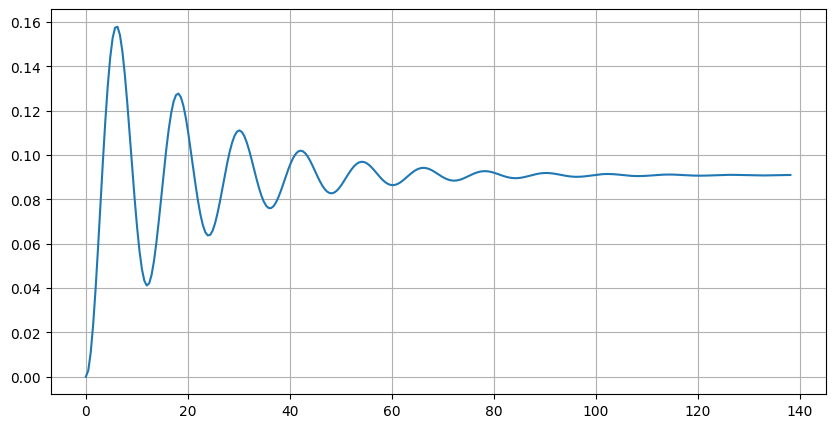

In [17]:
#реакция на ступенчатое воздействие при К = 1
t, y = control.step_response(Wfeedback)
plt.figure(figsize=(10,5))
plt.plot(t, y)
plt.grid()
plt.show()

In [18]:
sysABCD = control.tf2ss(Wfeedback)
print(sysABCD.A)
print(sysABCD.B)
print(sysABCD.C)

[[-0.1   -0.275]
 [ 1.     0.   ]]
[[1.]
 [0.]]
[[0.    0.025]]


In [19]:
class ODESolver:
  def __init__(self, f):
    # Wrap user’s f in a new function that always
    # converts list/tuple to array (or let array be array)
    self.model = f
    self.f = lambda t, x: np.asarray(f(t, x), float)

  def set_initial_condition(self, x0):
    if np.isscalar(x0):
      self.neq = 1 # scalar ODE
      x0 = float(x0)
    else:
      x0 = np.asarray(x0)
      self.neq = x0.size
    self.x0 = x0

# Compute solution for t_span[0] <= t <= t_span[1], using N steps
  def solve(self, t_span, N):
    t0, T = t_span
    self.dt = (T - t0) / N
    self.t = np.zeros(N + 1) # N steps ~ N+1 time points
    if self.neq == 1:
      self.x = np.zeros(N + 1)
    else:
      self.x = np.zeros((N + 1, self.neq))

    msg = "Please set initial condition before calling solve"
    assert hasattr(self, "x0"), msg

    self.t[0] = t0
    self.x[0] = self.x0
    for n in range(N):
      self.n = n
      self.t[n + 1] = self.t[n] + self.dt
      self.x[n + 1] = self.advance()
    return self.t, self.x

  def advance(self):
    raise NotImplementedError("Advance method is not implemented in the base class")

In [20]:
class RungeKutta4(ODESolver):
  def advance(self):
    x, f, n, t = self.x, self.f, self.n, self.t
    dt = self.dt
    dt2 = dt / 2.0
    k1 = f(t[n], x[n], )
    k2 = f(t[n] + dt2, x[n] + dt2 * k1, )
    k3 = f(t[n] + dt2, x[n] + dt2 * k2, )
    k4 = f(t[n] + dt, x[n] + dt * k3, )
    return x[n] + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

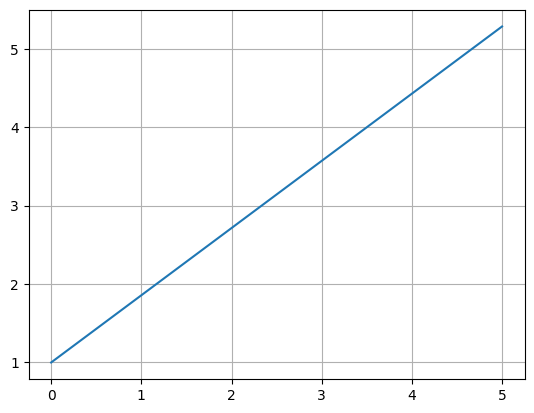

In [21]:
def f(t, x):
  return x + np.cos(t)
t_span = (0, 5)
N = 25

rk4 = RungeKutta4(f)
rk4.set_initial_condition(x0 = 3)
t_solve, x_solve = rk4.solve(t_span, N)
#plt.plot(t3, u3, label="Runge-Kutta 4")
plt.plot(t_span, f(t_span, t_span))
plt.grid()

In [23]:
class ABCDt:
  def __init__(self,mu,u,A,B):
    self.mu = mu
    self.u = u
    self.A = A
    self.B = B
  def __call__(self,t,x):
    time_delta = 1 - 0.5*np.sin(-2*t)
    dx1 = self.A[0,0] * x[0] * time_delta + self.A[0,1] * x[1] * time_delta + self.B[0,0]*self.u
    dx2 = self.A[1,0] * x[0] * time_delta + self.A[1,1] * x[1] * time_delta + self.B[1,0]*self.u
    return dx1,dx2

In [24]:
class ABCD:
  def __init__(self,mu,u,A,B):
    self.mu = mu
    self.u = u
    self.A = A
    self.B = B
  def __call__(self,t,x):
    dx1 = self.A[0,0] * x[0] + self.A[0,1] * x[1] + self.B[0,0]*self.u
    dx2 = self.A[1,0] * x[0] + self.A[1,1] * x[1] + self.B[1,0]*self.u
    return dx1, dx2

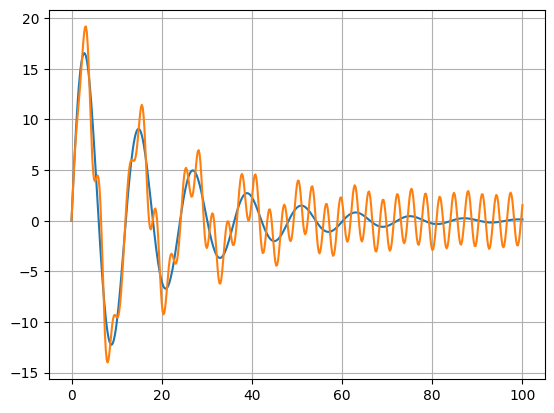

In [25]:
model = ABCD(mu=1 , u=10, A=sysABCD.A, B=sysABCD.B)
solver = RungeKutta4(model)
solver.set_initial_condition([0, 0])

model_t = ABCDt(mu = 1, u = 10, A=sysABCD.A, B=sysABCD.B)
solver_t = RungeKutta4(model_t)
solver_t.set_initial_condition([0, 0])

t  , x = solver.solve(t_span=(0,100),N=500)
t_t, x_t = solver_t.solve(t_span=(0,100),N=500)

plt.plot(t,x[:,0], t_t, x_t[:,0])
plt.grid()
plt.show()